<figure>
  <IMG src="figures/logo-esi-sba.png" WIDTH=300 height="100" ALIGN="right">
</figure>

# Practical Lab Series on Network Sciences   
*By Dr. Belkacem KHALDI (b.khaldi@esi-sba.dz)*

## Notebook 6: Introduction to GraphSAGE
This Jupyter Notebook is designed to help you grasp the most  different aspects of  GraphSAGE seen in the lecture.

## Install the required package

In [28]:
# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html

In [29]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [30]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.5.1+cpu.html


Looking in links: https://data.pyg.org/whl/torch-2.5.1+cpu.html


In [31]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__
print(torchversion)

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

2.5.1+cpu


# Dataset
Downloading the Pubmed Dataset and Displaying Key Informations about it
ubMed is part of the Planetoid dataset (MIT license). Here’s a quick summary:

- It contains 19,717 scientific publications about diabetes from PubMed’s database
- Node features are TF-IDF weighted word vectors with 500 dimensions, which is an efficient way of summarizing documents without transformers
- The task is quite straightforward since it’s a multi-class classification with three categories: diabetes mellitus experimental, diabetes mellitus type 1, and diabetes mellitus type 2

In [32]:
import torch
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [33]:
%pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [34]:
import torch
from torch_geometric.data import Data
import torch_scatter
import torch_sparse
import torch_cluster
import torch_geometric

print("Torch version:", torch.__version__)
print("PyTorch Geometric version:", torch_geometric.__version__)
print("Torch Scatter version:", torch_scatter.__version__)
print("Torch Sparse version:", torch_sparse.__version__)
print("Torch Cluster version:", torch_cluster.__version__)


Torch version: 2.5.1+cpu
PyTorch Geometric version: 2.7.0
Torch Scatter version: 2.1.2
Torch Sparse version: 0.6.18
Torch Cluster version: 1.6.3+pt25cpu


# Mini-batching
n PyG, neighbor sampling is implemented through the NeighborLoader object. Let’s say we want 5 neighbors and 10 of their neighbors (num_neighbors). As we discussed, we can also specify a batch_size to speed up the process by creating subgraphs for multiple target nodes.

In [35]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[388, 500], edge_index=[2, 450], y=[388], train_mask=[388], val_mask=[388], test_mask=[388], n_id=[388], e_id=[450], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[272, 500], edge_index=[2, 322], y=[272], train_mask=[272], val_mask=[272], test_mask=[272], n_id=[272], e_id=[322], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[298, 500], edge_index=[2, 346], y=[298], train_mask=[298], val_mask=[298], test_mask=[298], n_id=[298], e_id=[346], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[194, 500], edge_index=[2, 228], y=[194], train_mask=[194], val_mask=[194], test_mask=[194], n_id=[194], e_id=[228], input_id=[12], batch_size=12)


## Plot subgraphs

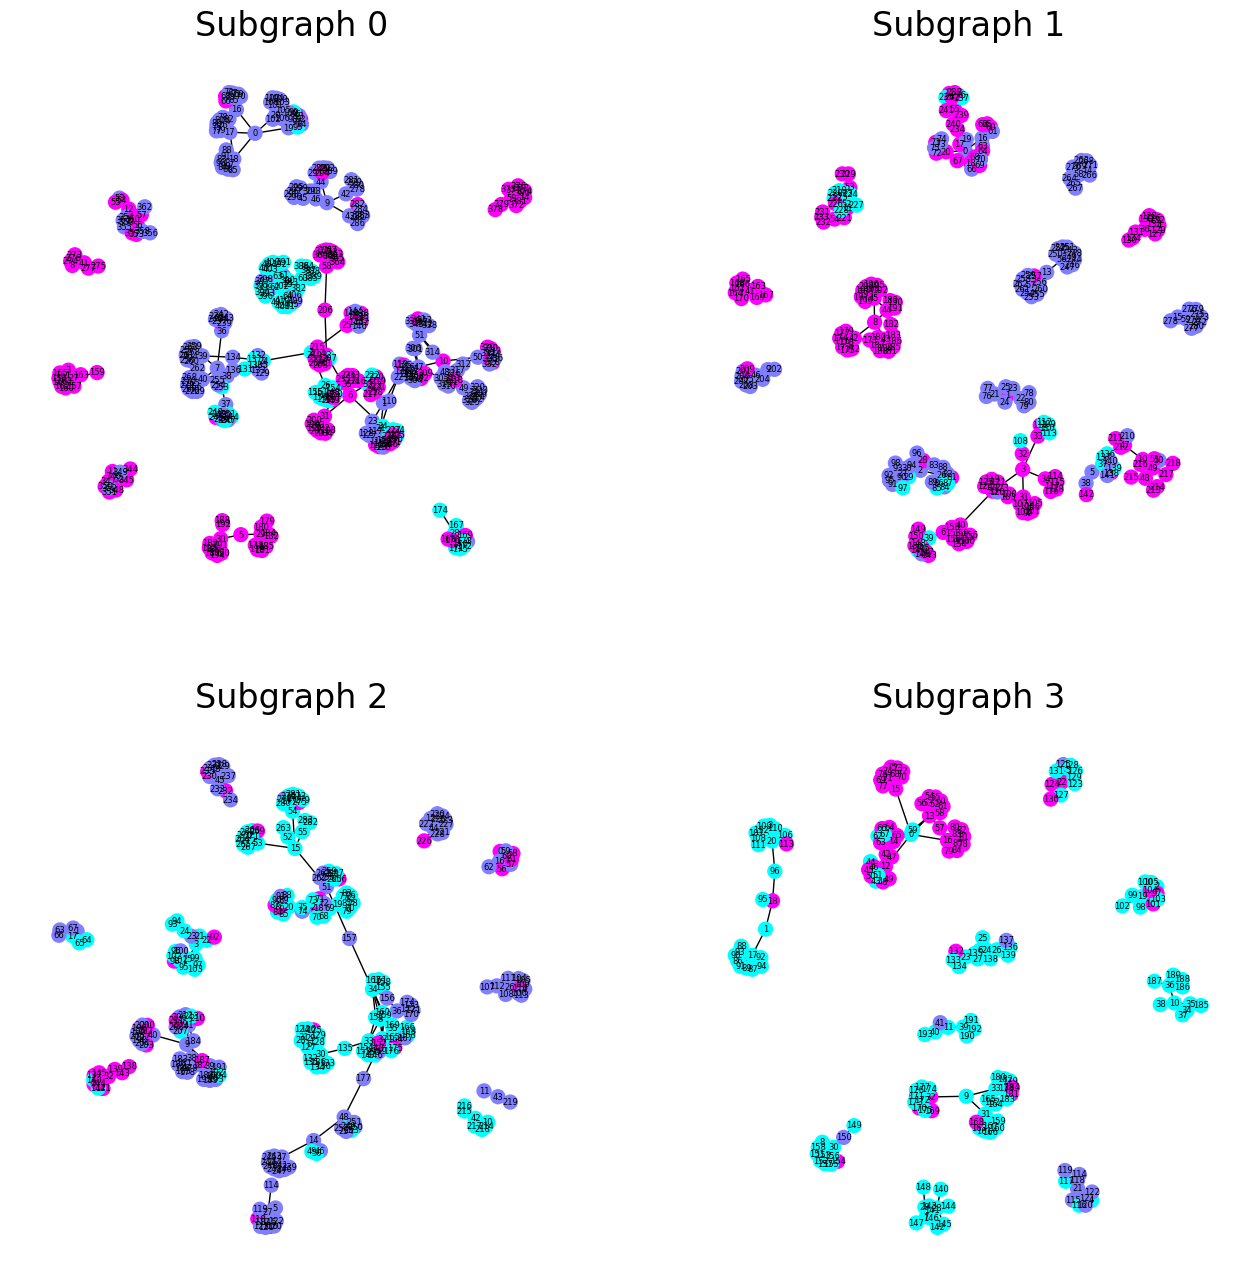

In [36]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}', fontsize=24)
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_color=subdata.y,
                    cmap="cool",
                    node_size=100,
                    font_size = 6
                    )
plt.show()

# Plot node degrees

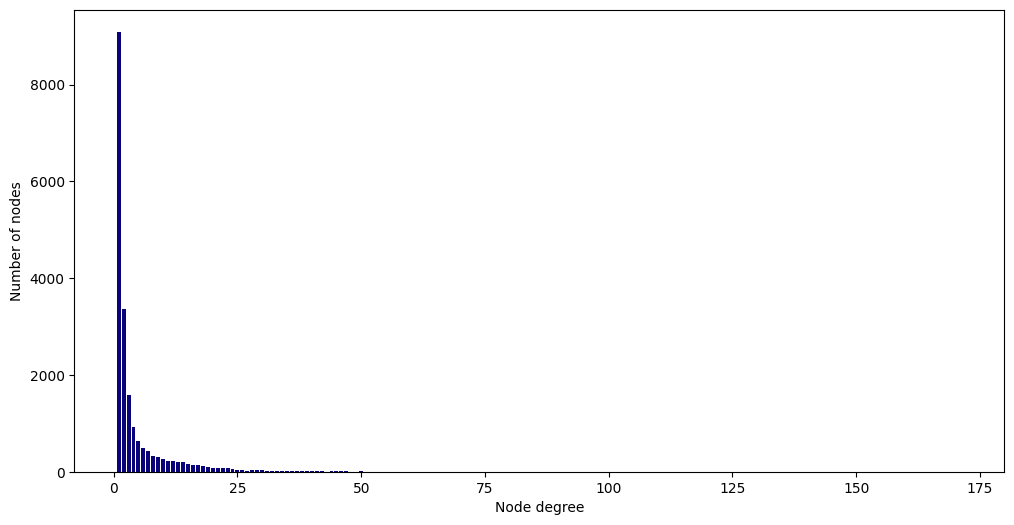

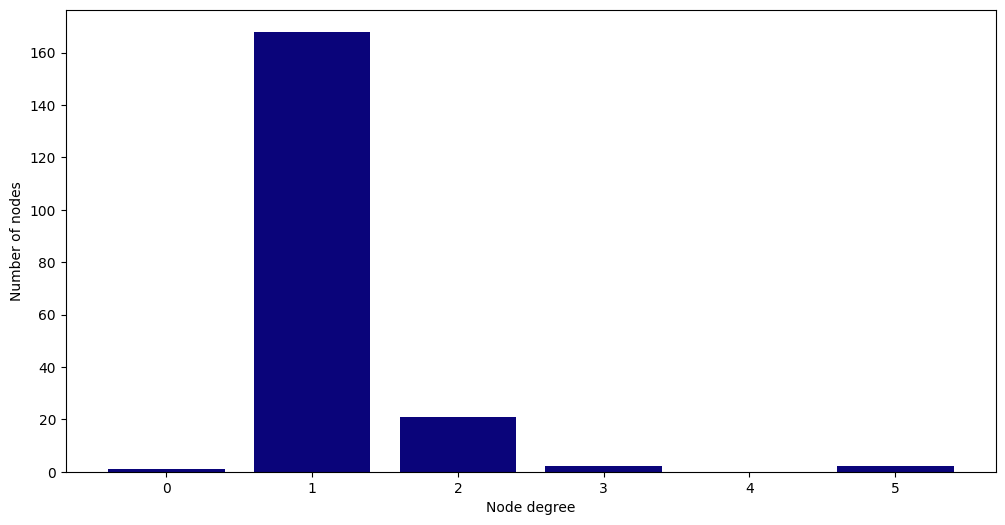

In [37]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
  # Get list of degrees for each node
  degrees = degree(data.edge_index[0]).numpy()

  # Count the number of nodes for each degree
  numbers = Counter(degrees)

  # Bar plot
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Number of nodes')
  plt.bar(numbers.keys(),
          numbers.values(),
          color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)

# Implement GraphSage vs. GAT vs. GCN on Pubmed Dataset

In [38]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv


class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        _, out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1),
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1),
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Train GraphSAGE

In [39]:
%%time
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 0.309 | Train Acc:  30.24% | Val Loss: 1.12 | Val Acc: 27.23%
Epoch  10 | Train Loss: 0.032 | Train Acc: 100.00% | Val Loss: 0.67 | Val Acc: 73.54%
Epoch  20 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.55 | Val Acc: 78.77%
Epoch  30 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 0.54 | Val Acc: 75.76%
Epoch  40 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 70.63%
Epoch  50 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.52 | Val Acc: 81.42%
Epoch  60 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 75.23%
Epoch  70 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 0.45 | Val Acc: 85.83%
Epoch  80 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 75.21%
Epoch  90 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 0.42 | Val Acc: 86.04%
Epoch 100 | Train Loss: 0.002 | Train Acc: 100.00

# Train GCN

In [40]:
%%time

# Create GCN
gcn = GCN(dataset.num_features, 64, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, 200)

# Test
print(f'\nGCN test accuracy: {test(gcn, data)*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(500, 64)
  (gcn2): GCNConv(64, 3)
)


Epoch   0 | Train Loss: 1.099 | Train Acc:  33.33% | Val Loss: 1.10 | Val Acc: 37.60%
Epoch  10 | Train Loss: 0.741 | Train Acc:  91.67% | Val Loss: 0.90 | Val Acc: 71.40%
Epoch  20 | Train Loss: 0.422 | Train Acc:  95.00% | Val Loss: 0.69 | Val Acc: 74.00%
Epoch  30 | Train Loss: 0.212 | Train Acc:  98.33% | Val Loss: 0.63 | Val Acc: 73.80%
Epoch  40 | Train Loss: 0.133 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 77.00%
Epoch  50 | Train Loss: 0.112 | Train Acc: 100.00% | Val Loss: 0.64 | Val Acc: 76.60%
Epoch  60 | Train Loss: 0.088 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 77.20%
Epoch  70 | Train Loss: 0.092 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 74.60%
Epoch  80 | Train Loss: 0.074 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 78.00%
Epoch  90 | Train Loss: 0.063 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 75.40%
Epoch 100 | Train Loss: 0.068 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 78.00%
Epoch 110 | Train Loss: 0.061 | Train Acc: 100.00% | V

# Train GAT

In [41]:
%%time
# Create GAT
gat = GAT(dataset.num_features, 64, dataset.num_classes)
print(gat)

# Train
gat.fit(data, 200)

# Test
print(f'\nGAT test accuracy: {test(gat, data)*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(500, 64, heads=8)
  (gat2): GATv2Conv(512, 3, heads=8)
)
Epoch   0 | Train Loss: 3.177 | Train Acc:   1.67% | Val Loss: 3.19 | Val Acc: 0.20%
Epoch  10 | Train Loss: 0.708 | Train Acc:  90.00% | Val Loss: 0.86 | Val Acc: 71.40%
Epoch  20 | Train Loss: 0.358 | Train Acc:  93.33% | Val Loss: 0.66 | Val Acc: 75.40%
Epoch  30 | Train Loss: 0.175 | Train Acc:  96.67% | Val Loss: 0.59 | Val Acc: 77.60%
Epoch  40 | Train Loss: 0.127 | Train Acc:  98.33% | Val Loss: 0.61 | Val Acc: 75.40%
Epoch  50 | Train Loss: 0.087 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 79.00%
Epoch  60 | Train Loss: 0.082 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 77.60%
Epoch  70 | Train Loss: 0.067 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 76.00%
Epoch  80 | Train Loss: 0.059 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 77.00%
Epoch  90 | Train Loss: 0.053 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 77.40%
Epoch 100 | Train Loss: 0.053 | Train Acc: 100.00% | Val Lo

Considering this dataset’s unfavorable train/test split, we obtain a decent test accuracy.
However, GraphSAGE gets a lower average accuracy than a GCN (-0.5%) or a GAT (-1.4%) on
PubMed. So why should we use it?
The answer is evident when you train the three models – GraphSAGE is extremely fast. On a consumer
GPU, it is 4 times faster than a GCN and 88 times faster than a GAT. Even if GPU memory was not
an issue, GraphSAGE could handle larger graphs, producing better results than small networks

# Challenge

Test GraphSAGE with te two datasets seen in the previous lectures:
- The cora DataSet
- The facebook Page DataSet

#### Facebook page dataset

In [42]:
from torch_geometric.datasets import FacebookPagePage

# Load the Facebook Page-Page dataset
dataset_fsb = FacebookPagePage(root=".")
data_fsb = dataset_fsb[0]

# Number of nodes
num_nodes = data_fsb.num_nodes

# Create train, validation, and test masks
data_fsb.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data_fsb.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data_fsb.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assign masks based on node indices
data_fsb.train_mask[:18000] = True
data_fsb.val_mask[18000:20000] = True
data_fsb.test_mask[20000:] = True

# Print a summary of the dataset
print(f"Dataset: {dataset_fsb}")
print(f"Number of nodes: {data_fsb.num_nodes}")
print(f"Number of edges: {data_fsb.num_edges}")
print(f"Number of features: {data_fsb.num_node_features}")
num_classes = len(data_fsb.y.unique())
print(f"Number of classes: {num_classes}")
print(f"Train nodes: {data_fsb.train_mask.sum()}")
print(f"Validation nodes: {data_fsb.val_mask.sum()}")
print(f"Test nodes: {data_fsb.test_mask.sum()}")


Dataset: FacebookPagePage()
Number of nodes: 22470
Number of edges: 342004
Number of features: 128
Number of classes: 4
Train nodes: 18000
Validation nodes: 2000
Test nodes: 2470


In [43]:

fb_model = GraphSAGE(data_fsb.num_node_features, 64, num_classes)


In [44]:
train_loader = NeighborLoader(
    data_fsb,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data_fsb.train_mask,
)

In [45]:
print("Training GraphSAGE on Facebook Dataset...")
fb_model.fit(data_fsb, epochs=1 00)
fb_test_acc = test(fb_model, data_fsb)
print(f"Facebook Test Accuracy: {fb_test_acc:.2f}")

Training GraphSAGE on Facebook Dataset...
Epoch   0 | Train Loss: 0.000 | Train Acc:  81.18% | Val Loss: 0.56 | Val Acc: 78.03%
Epoch  10 | Train Loss: 0.000 | Train Acc:  82.51% | Val Loss: 0.56 | Val Acc: 78.52%
Epoch  20 | Train Loss: 0.000 | Train Acc:  82.45% | Val Loss: 0.56 | Val Acc: 78.48%
Epoch  30 | Train Loss: 0.000 | Train Acc:  82.41% | Val Loss: 0.56 | Val Acc: 78.27%
Epoch  40 | Train Loss: 0.000 | Train Acc:  82.44% | Val Loss: 0.57 | Val Acc: 78.21%
Epoch  50 | Train Loss: 0.000 | Train Acc:  82.36% | Val Loss: 0.57 | Val Acc: 78.25%
Epoch  60 | Train Loss: 0.000 | Train Acc:  82.40% | Val Loss: 0.56 | Val Acc: 78.38%
Epoch  70 | Train Loss: 0.000 | Train Acc:  82.55% | Val Loss: 0.57 | Val Acc: 78.45%
Epoch  80 | Train Loss: 0.000 | Train Acc:  82.48% | Val Loss: 0.57 | Val Acc: 78.19%
Epoch  90 | Train Loss: 0.000 | Train Acc:  82.38% | Val Loss: 0.56 | Val Acc: 78.51%
Epoch 100 | Train Loss: 0.000 | Train Acc:  82.41% | Val Loss: 0.56 | Val Acc: 78.23%
Facebook Tes

#### Cora Dataset

In [46]:
# Import necessary libraries
from torch_geometric.datasets import Planetoid
# Download the Cora dataset using Planetoid
dataset_cora = Planetoid(root=".", name="Cora")
# Access the dataset's data
data_cora = dataset_cora[0]

# Print general information about the dataset
print(f'Dataset: {dataset_cora}')
print('---------------')
print(f'Number of graphs: {len(dataset_cora)}')
print(f'Number of nodes: {data_cora.x.shape[0]}')
print(f'Number of features: {dataset_cora.num_features}')
print(f'Number of classes: {dataset_cora.num_classes}')

Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7


Processing...
Done!


In [47]:

cora_model = GraphSAGE(data_cora.num_node_features, 64, dataset_cora.num_classes)


In [48]:
train_loader = NeighborLoader(
    data_cora,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data_cora.train_mask,
)

In [50]:
print("Training GraphSAGE on CORA Dataset...")
cora_model.fit(data_cora, epochs=100)
cora_test_acc = test(cora_model, data_cora)
print(f"CORA Test Accuracy: {cora_test_acc:.2f}")

Training GraphSAGE on CORA Dataset...
Epoch   0 | Train Loss: 0.240 | Train Acc:  30.62% | Val Loss: 1.93 | Val Acc: 23.34%
Epoch  10 | Train Loss: 0.003 | Train Acc:  99.52% | Val Loss: 1.05 | Val Acc: 64.65%
Epoch  20 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 1.14 | Val Acc: 61.47%
Epoch  30 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.25 | Val Acc: 61.68%
Epoch  40 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.31 | Val Acc: 59.70%
Epoch  50 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.27 | Val Acc: 60.88%
Epoch  60 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 1.44 | Val Acc: 57.52%
Epoch  70 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.31 | Val Acc: 61.61%
Epoch  80 | Train Loss: 0.000 | Train Acc:  99.64% | Val Loss: 1.56 | Val Acc: 57.78%
Epoch  90 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 1.66 | Val Acc: 57.64%
Epoch 100 | Train Loss: 0.001 | Train Acc:  99.62% | Val Loss: 1.39 | Val Acc: 63.00%
CORA Test Accura